In this notebook, we will preprocess the data via SentenceTransformer. Then we will create an extensive algorithm that calculates the top 3 products per meta-category. For this calculation, we will also use the RandomForest model that we created earlier for Sentiment analysis. 

In [ ]:
# First we download the dataset from the kagglehub URL and save it to a dataframe
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")


# Download the datasets from the specified path, from previous notebook we know the shape of the data and the columns we are interested in
file_path1 = os.path.join(path, "1429_1.csv")
df1 = pd.read_csv(file_path1)
file_path2 = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df2 = pd.read_csv(file_path2)
file_path3 = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv(file_path3)

C:\Users\karel\AppData\Local\Temp\ipykernel_24156\2756058187.py:11: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file_path1)


In [3]:
# Import pickle dictionary to apply our meta-category mapping to the dataframes once these are merged
import pickle
from pathlib import Path
# Load the meta-category mapping from the pickle file

current_dir = Path.cwd()
parent_dir = current_dir.parent

pickle_file_path = parent_dir / "Joblib_files" / "unique_categories_dict.pkl"

with open(pickle_file_path, "rb") as f:
    meta_category_mapping = pickle.load(f)
print("Meta-category mapping loaded successfully.")
print(meta_category_mapping)

Meta-category mapping loaded successfully.
{'AA,AAA,Electronics Features,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care': 'Batteries', 'AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care': 'Batteries', 'Accessories,USB Cables,Computers & Accessories,Computer Accessories & Peripherals,Electronics,Cables,Cables & Interconnects': 'Portable Electronics', 'Amazon Device Accessories,Kindle Store,Kindle Touch (4th Generation) Accessories,Kindle E-Reader Accessories,Covers,Kindle Touch (4th Generation) Covers': 'Portable Electronics', 'Amazon Devices & Accessories,Amazon Device Accessories,Power Ad

In [4]:
# print the columns of the dataframes
print("Columns in df1:", df1.columns)
print("Columns in df2:", df2.columns)
print("Columns in df3:", df3.columns)

Columns in df1: Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
Columns in df2: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')
Columns in df3: Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCat

In [ ]:
# Columns to keep


# Filter the dataframes to keep only the relevant columns
columns_df1 = ['name', 'asins', 'categories', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title']
columns_other = columns_df1 + ['imageURLs']
df1_filtered = df1[columns_df1]
df1_filtered['imageURLs'] = "https://upload.wikimedia.org/wikipedia/commons/a/ac/No_image_available.svg"
df2_filtered = df2[columns_other]
df3_filtered = df3[columns_other]
# Concatenate the filtered dataframes
df_combined = pd.concat([df1_filtered, df2_filtered, df3_filtered], ignore_index=True)
# Append df_combined with the meta-category mapping
df_combined['meta_category'] = df_combined['categories'].map(meta_category_mapping)



# print the unique values of the meta_category column
print("Unique meta-categories in the combined dataframe:")
print(df_combined['meta_category'].unique())
# print the number of rows for each meta-category
print("Number of rows for each meta-category:")
print(df_combined['meta_category'].value_counts())


Unique meta-categories in the combined dataframe:
['Portable Electronics' 'Office Supplies' nan 'Connected Home Electronics'
 'Kitchen Storage' 'Batteries' 'Pet Products']
Number of rows for each meta-category:
meta_category
Portable Electronics          37662
Connected Home Electronics    14000
Batteries                     12071
Office Supplies                4223
Pet Products                      6
Kitchen Storage                   3
Name: count, dtype: int64


C:\Users\karel\AppData\Local\Temp\ipykernel_24156\3286339815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtered['imageURLs'] = "https://upload.wikimedia.org/wikipedia/commons/a/ac/No_image_available.svg"


In [6]:
# print the unique values in the meta_category column
print("Unique values in meta_category column:")
print(df_combined['meta_category'].unique())

# print the number of unique values in the asin column
print("Number of unique ASINs:", df_combined['asins'].nunique())

Unique values in meta_category column:
['Portable Electronics' 'Office Supplies' nan 'Connected Home Electronics'
 'Kitchen Storage' 'Batteries' 'Pet Products']
Number of unique ASINs: 94


In [7]:
import re
# Drop rows with missing review text or rating
df_combined = df_combined.dropna(subset=["reviews.text", "reviews.rating"])


Meta-category counts:
meta_category
Portable Electronics          37633
Connected Home Electronics    14000
Batteries                     12071
Office Supplies                4223
Pet Products                      6
Kitchen Storage                   2
Name: count, dtype: int64


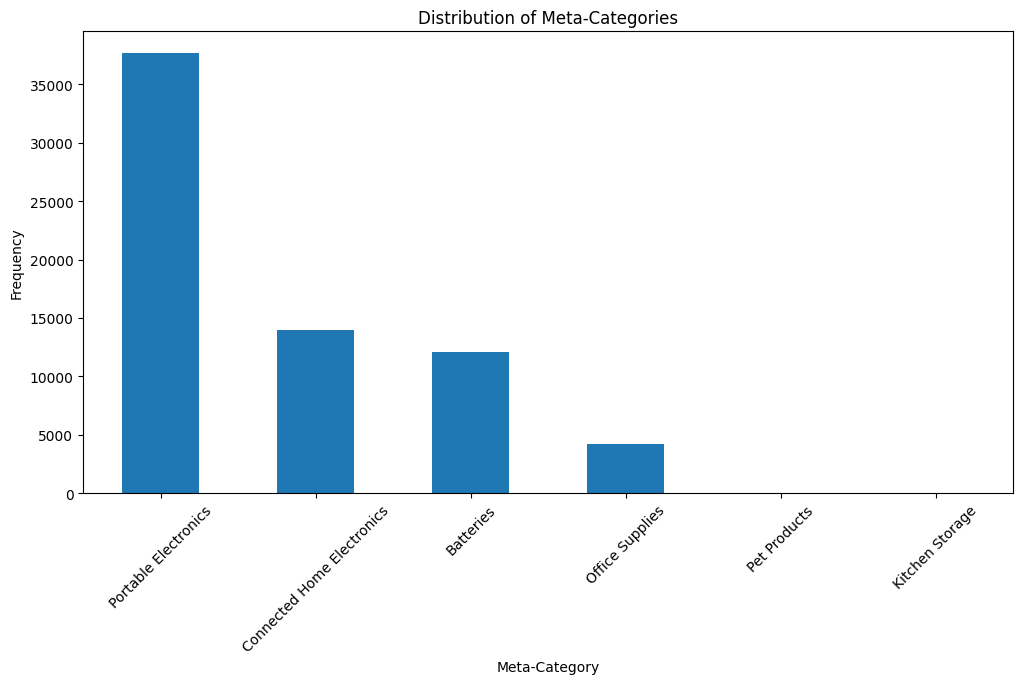

In [9]:
# Visualize the distribution of meta-categories
import matplotlib.pyplot as plt

meta_category_counts = df_combined["meta_category"].value_counts()
print("Meta-category counts:")
print(meta_category_counts)

plt.figure(figsize=(12, 6))
meta_category_counts.plot(kind="bar")
plt.title("Distribution of Meta-Categories")
plt.xlabel("Meta-Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [11]:
# Debug your current mapping
print("Original categories distribution:")
print(df_combined['categories'].value_counts().head(20))

print("\nSample categories that might contain pet/kitchen products:")
pet_kitchen_categories = df_combined[df_combined['categories'].str.contains(
    'pet|kitchen|storage|food|animal|dog|cat', case=False, na=False
)]['categories'].value_counts()
print(pet_kitchen_categories)

# Print the number of unique categories in pet_kitchen_categories
print("\nNumber of unique categories in pet/kitchen products:", pet_kitchen_categories.nunique())


Original categories distribution:
categories
Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    10966
AA,AAA,

In [15]:
# Create a copy of the DataFrame to avoid modifying the original
df_combined_copy = df_combined.copy()
df_combined_copy2 = df_combined.copy()



In [13]:
# More inclusive mapping
def create_expanded_mapping(df):
    expanded_mapping = {}
    
    # Pet Products - be more inclusive
    pet_keywords = ['pet', 'dog', 'cat', 'animal', 'puppy', 'kitten', 'bird', 'fish', 
                   'reptile', 'hamster', 'rabbit', 'guinea pig', 'leash', 'collar', 
                   'treat', 'toy', 'cage', 'aquarium', 'litter', 'grooming']
    
    # Kitchen Storage - broader terms
    kitchen_keywords = ['kitchen', 'storage', 'container', 'organizer', 'pantry', 
                       'cabinet', 'drawer', 'shelf', 'rack', 'holder', 'dispenser',
                       'canister', 'jar', 'basket', 'bin']
    
    for category in df['categories'].dropna().unique():
        category_lower = category.lower()
        
        # Check for pet products
        if any(keyword in category_lower for keyword in pet_keywords):
            expanded_mapping[category] = 'Pet Products'
        
        # Check for kitchen storage
        elif any(keyword in category_lower for keyword in kitchen_keywords):
            expanded_mapping[category] = 'Kitchen Storage'
        
        # Keep your existing mappings for other categories
        # ... (add your existing logic here)
    
    return expanded_mapping

# Apply the expanded mapping
expanded_mapping = create_expanded_mapping(df_combined)
# Update the meta_category_mapping with the expanded mapping
meta_category_mapping.update(expanded_mapping)
# Apply the updated mapping to the dataframe
df_combined_copy['meta_category'] = df_combined['categories'].map(meta_category_mapping)

# Print the updated unique values in the meta_category column
print("Updated unique values in meta_category column:")
print(df_combined_copy['meta_category'].unique())
# Print the number of rows for each meta-category after the update
print("Updated number of rows for each meta-category:")
print(df_combined_copy['meta_category'].value_counts())

Updated unique values in meta_category column:
['Portable Electronics' 'Kitchen Storage' 'Pet Products' 'Office Supplies'
 nan 'Connected Home Electronics' 'Batteries']
Updated number of rows for each meta-category:
meta_category
Portable Electronics          22024
Pet Products                  16135
Batteries                     12071
Kitchen Storage                6967
Connected Home Electronics     6544
Office Supplies                4202
Name: count, dtype: int64


In [22]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def create_semantic_mapping(df, model, similarity_threshold=0.3):
    """
    Create category mapping using semantic similarity with sentence transformers
    
    Args:
        df: DataFrame with 'name' and 'categories' columns
        model: Pre-loaded SentenceTransformer model
        similarity_threshold: Minimum similarity score to assign category (0-1)
    
    Returns:
        DataFrame with new 'meta_category_semantic' column
    """
    
    # Define reference phrases for each meta-category
    # These should be comprehensive and representative
    category_references = {
        'Pet Products': [
            'dog food and treats for pets',
            'cat toys and pet supplies', 
            'pet grooming and care products',
            'dog collars leashes and pet accessories',
            'pet beds and comfort items',
            'bird cage and small animal supplies',
            'aquarium fish tank accessories',
            'pet health and wellness products',
            'cat litter and pet hygiene',
            'dog training and behavior products'
        ],
        
        'Kitchen Storage': [
            'kitchen food storage containers',
            'pantry organization and storage solutions',
            'kitchen cabinet organizers and racks', 
            'food preservation containers and jars',
            'kitchen drawer organization systems',
            'spice storage and kitchen organization',
            'kitchen countertop storage solutions',
            'refrigerator and freezer storage containers',
            'kitchen utensil holders and organizers',
            'pantry shelving and storage baskets'
        ],
        
        'Portable Electronics': [
            'smartphone mobile phone accessories',
            'tablet computers and portable devices',
            'wireless headphones and earbuds',
            'portable speakers and audio devices',
            'laptop computers and portable technology',
            'portable chargers and power banks',
            'bluetooth wireless portable devices',
            'portable gaming devices and electronics',
            'mobile device cases and protection',
            'portable cameras and photography equipment'
        ],
        
        'Connected Home Electronics': [
            'smart home automation devices',
            'wifi connected home electronics',
            'smart security cameras and systems',
            'home automation hubs and controllers',
            'smart lighting and electrical controls',
            'connected home monitoring devices',
            'smart doorbell and home security',
            'home network and wifi equipment',
            'smart thermostats and climate control',
            'voice controlled smart home devices'
        ],
        
        'Batteries': [
            'alkaline disposable batteries',
            'rechargeable battery packs and chargers',
            'lithium ion batteries and power sources',
            'battery powered devices and accessories',
            'portable power banks and battery chargers',
            'household batteries and power supplies',
            'rechargeable aa aaa batteries',
            'battery testing and maintenance equipment',
            'backup power and battery systems',
            'electronic device batteries and chargers'
        ],
        
        'Office Supplies': [
            'office stationery and writing supplies',
            'business office organization products',
            'desk accessories and office furniture',
            'office paper and printing supplies',
            'office filing and document organization',
            'business cards and office printing',
            'office electronics and equipment',
            'workplace organization and storage',
            'office meeting and presentation supplies',
            'business office technology accessories'
        ]
    }
    
    print("Creating reference embeddings for meta-categories...")
    
    # Create embeddings for all reference phrases
    category_embeddings = {}
    for category, phrases in category_references.items():
        # Embed all reference phrases for this category
        phrase_embeddings = model.encode(phrases, convert_to_tensor=False)
        # Use mean embedding as category representative
        category_embeddings[category] = np.mean(phrase_embeddings, axis=0)
    
    print("Creating product embeddings...")
    
    # Prepare product text (combine name and categories)
    df['product_text'] = (df['name'].fillna('').astype(str) + ' ' + 
                         df['categories'].fillna('').astype(str)).str.strip()
    
    # Remove empty entries
    valid_products = df['product_text'] != ''
    
    # Create embeddings for products (batch processing for efficiency)
    print(f"Embedding {valid_products.sum()} valid products...")
    product_embeddings = model.encode(
        df[valid_products]['product_text'].tolist(), 
        convert_to_tensor=False,
        show_progress_bar=True,
        batch_size=32  # Adjust based on your memory
    )
    
    print("Calculating similarities and assigning categories...")
    
    # Initialize results
    df['meta_category_semantic'] = 'Unknown'
    df['similarity_score'] = 0.0
    df['similarity_scores_all'] = None
    
    # Calculate similarities for valid products
    valid_indices = df[valid_products].index
    
    for i, idx in enumerate(valid_indices):
        product_embedding = product_embeddings[i].reshape(1, -1)
        
        # Calculate similarity to each category
        similarities = {}
        for category, cat_embedding in category_embeddings.items():
            cat_embedding = cat_embedding.reshape(1, -1)
            similarity = cosine_similarity(product_embedding, cat_embedding)[0][0]
            similarities[category] = similarity
        
        # Store all similarities for analysis
        df.at[idx, 'similarity_scores_all'] = similarities
        
        # Find best match
        best_category = max(similarities, key=similarities.get)
        best_score = similarities[best_category]
        
        # Assign category if above threshold
        if best_score >= similarity_threshold:
            df.at[idx, 'meta_category_semantic'] = best_category
            df.at[idx, 'similarity_score'] = best_score
        else:
            df.at[idx, 'meta_category_semantic'] = 'Unknown'
            df.at[idx, 'similarity_score'] = best_score
    
    return df

def analyze_semantic_mapping(df, top_n_samples=5):
    """
    Analyze the results of semantic mapping
    """
    
    print("=== SEMANTIC MAPPING ANALYSIS ===\n")
    
    # Distribution
    category_counts = df['meta_category_semantic'].value_counts()
    print("Category distribution:")
    for cat, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{cat}: {count} ({percentage:.2f}%)")
    
    # Similarity score statistics
    print(f"\nSimilarity scores:")
    print(f"Mean: {df['similarity_score'].mean():.3f}")
    print(f"Std: {df['similarity_score'].std():.3f}")
    print(f"Min: {df['similarity_score'].min():.3f}")
    print(f"Max: {df['similarity_score'].max():.3f}")
    
    # Show top matches for each category
    for category in category_counts.index:
        if category != 'Unknown':
            print(f"\n=== TOP {top_n_samples} {category.upper()} MATCHES ===")
            
            cat_products = df[df['meta_category_semantic'] == category].nlargest(
                top_n_samples, 'similarity_score'
            )
            
            for idx, row in cat_products.iterrows():
                print(f"Score: {row['similarity_score']:.3f}")
                
                # Safe handling of potentially NaN values
                name_str = str(row.get('name', 'N/A')) if pd.notna(row.get('name')) else 'N/A'
                categories_str = str(row.get('categories', 'N/A')) if pd.notna(row.get('categories')) else 'N/A'
                
                print(f"Product: {name_str[:60]}")
                print(f"Category: {categories_str[:60]}")
                print("---")
    
    # Show borderline cases (low similarity scores)
    print(f"\n=== BORDERLINE CASES (lowest similarity scores) ===")
    assigned_products = df[df['meta_category_semantic'] != 'Unknown']
    if len(assigned_products) > 0:
        borderline = assigned_products.nsmallest(top_n_samples, 'similarity_score')
        
        for idx, row in borderline.iterrows():
            print(f"Score: {row['similarity_score']:.3f} -> {row['meta_category_semantic']}")
            
            # Safe handling of potentially NaN values
            name_str = str(row.get('name', 'N/A')) if pd.notna(row.get('name')) else 'N/A'
            categories_str = str(row.get('categories', 'N/A')) if pd.notna(row.get('categories')) else 'N/A'
            
            print(f"Product: {name_str[:60]}")
            print(f"Category: {categories_str[:60]}")
            print("---")

def tune_similarity_threshold(df, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5]):
    """
    Test different similarity thresholds to find optimal balance
    """
    
    print("=== THRESHOLD TUNING ===\n")
    
    for threshold in thresholds:
        # Apply threshold
        assigned = (df['similarity_score'] >= threshold) & (df['similarity_score'] > 0)
        df_temp = df.copy()
        df_temp.loc[~assigned, 'meta_category_semantic'] = 'Unknown'
        
        # Calculate stats
        category_counts = df_temp['meta_category_semantic'].value_counts()
        assigned_count = len(df_temp) - category_counts.get('Unknown', 0)
        assigned_pct = (assigned_count / len(df_temp)) * 100
        
        print(f"Threshold {threshold:.1f}: {assigned_count} assigned ({assigned_pct:.1f}%)")
        
        # Show category breakdown
        for cat, count in category_counts.items():
            if cat != 'Unknown':
                print(f"  {cat}: {count}")
        print()

# Usage example:
def apply_semantic_mapping_pipeline(df_combined, model):
    """
    Complete pipeline for applying semantic mapping
    """
    
    # Step 1: Apply semantic mapping
    print("Step 1: Applying semantic mapping...")
    df_result = create_semantic_mapping(df_combined, model, similarity_threshold=0.25)
    
    # Step 2: Analyze results
    print("\nStep 2: Analyzing results...")
    analyze_semantic_mapping(df_result)
    
    # Step 3: Tune threshold if needed
    print("\nStep 3: Threshold analysis...")
    tune_similarity_threshold(df_result)
    
    return df_result

# Integration with your existing code:
"""
# Replace your existing mapping with:
df_combined_semantic = apply_semantic_mapping_pipeline(df_combined, model)

# Use the semantic categories
df_combined['meta_category'] = df_combined_semantic['meta_category_semantic']
"""

# Apply semantic mapping
df_combined_semantic = apply_semantic_mapping_pipeline(df_combined_copy2, model)

# Replace your existing meta_category column
df_combined_copy2['meta_category'] = df_combined_semantic['meta_category_semantic']

Step 1: Applying semantic mapping...
Creating reference embeddings for meta-categories...
Creating product embeddings...
Embedding 67958 valid products...


Batches:   0%|          | 0/2124 [00:00<?, ?it/s]

Calculating similarities and assigning categories...

Step 2: Analyzing results...
=== SEMANTIC MAPPING ANALYSIS ===

Category distribution:
Portable Electronics: 45650 (67.17%)
Batteries: 12264 (18.05%)
Connected Home Electronics: 9504 (13.99%)
Office Supplies: 532 (0.78%)
Pet Products: 6 (0.01%)
Kitchen Storage: 2 (0.00%)

Similarity scores:
Mean: 0.390
Std: 0.052
Min: 0.256
Max: 0.626

=== TOP 5 PORTABLE ELECTRONICS MATCHES ===
Score: 0.536
Product: N/A
Category: Power Adapters & Cables,Electronics,USB Cables
---
Score: 0.536
Product: N/A
Category: Power Adapters & Cables,Electronics,USB Cables
---
Score: 0.536
Product: N/A
Category: Power Adapters & Cables,Electronics,USB Cables
---
Score: 0.536
Product: N/A
Category: Power Adapters & Cables,Electronics,USB Cables
---
Score: 0.536
Product: N/A
Category: Power Adapters & Cables,Electronics,USB Cables
---

=== TOP 5 BATTERIES MATCHES ===
Score: 0.474
Product: AmazonBasics AAA Performance Alkaline Batteries (36 Count)
Category: AA,AAA

In [ ]:
# Print the final unique values in the meta_category column
print("Final unique values in meta_category column:")
print(df_combined['meta_category'].unique())

# Print random examples from each meta-category
for category in df_combined['meta_category'].unique():
    print(f"\nRandom examples from category '{category}':")
    examples = df_combined[df_combined['meta_category'] == category].sample(n=3, random_state=42)
    for _, row in examples.iterrows():
        print(f"Product: {row['name'][:60]}")
        print(f"Category: {row['categories'][:60]}")
        print(f"Review: {row['reviews.text'][:60]}")
        print("---")



In [ ]:
# Save the final DataFrame to a CSV file to be used in the final file
output_path = parent_dir / "Joblib_files" / "processed and embedded dataset.csv"
df_combined.to_csv(output_path, index=False)
print(f"Processed dataset saved to {output_path}")
